# Tarea 1: Hierarchical Attention
Guillermo Segura Gómez

La tarea de Author Profiling la podemos ver como un problema de clasificación supervisada para identificar rasgos demográficos (e.g., genero, edad, nacionalidad, rasgos de personalidad, etc.)  de alguna población objetivo. En esta tarea se te proporciona un conjunto de datos de perfiles de usuarios de twitter (solo para español). Cada usuario tiene un conjunto de tweets y en un archivo truth.txt en el que encontrarás las etiquetas objetivo. Para esta tarea solamente las de nacionalidad. Los datos pertenecen a la [tarea](https://pan.webis.de/clef17/pan17-web/author-profiling.html).

Con PyTorch haga lo siguiente y ESCRIBA UN BREVE comentario para cada punto:

1) 10pts Haga el preprocesamiento que usted considere para limpiar y extraer la información de los documentos. Explique qué hizo y por qué.

2) 40pts Diseñe un clasificador con alguna RNN con atención en jerárquia (como en el paper adjunto) que codifique cada perfil de usuario con todos sus tweets y clasifique. El primer nivel intuitivamente recibe embeddings de palabras, el segundo de tweets.

3) 30pts Discuta brevemente el rendimiento del modelo anterior. Para el punto anterior, construya visualizaciones como en la Figura 6 del paper de atención jerárquica y discuta.

4) 20pts Eché un ojo a los resultados que el profesor obtuvo sin [deep learning]( http://ceur-ws.org/Vol-1866/paper_109.pdf) y discuta lo siguiente respecto a tu modelo de RNN con atención en jerarquía:

4.1) ¿Le ganó a la mejor propuesta de representaciones distribucionales según lo reportado por el profesor? Si no fue así: ¿Le ganó a la Bolsa de Términos con SVM reportada por el profesor?
4.2) ¿Por que cree que NO o SI le ganó? Discuta.
4.3) ¿Qué usó el primer lugar de la competencia? (Basile, et al.) [Consulte](http://ceur-ws.org/Vol-1866/)
4.4) ¿Cuántos y que competidores usaron deep learning? En una o dos oraciones escriba qué hicieron, Y PORQUE crees que obtuvieron ese desempeño.

5) Opcional: 10pts extra para esta tarea: haga una comparación que muestre si la atención en jerarquía es util vs no tenerla (e.g., sin atención o tener un solo nivel de atención)

IMPORTANTE: Indique CLARAMENTE en cada parte del Notebook dónde se abordan cada uno de los 7 puntos para su revisión.

Sí necesita crear o leer archivos adicionales, entregará todo en una carpeta GDrive a través de un link compartido en classroom en su entrega, y ADEMAS empaquetado en un Zip como archivo con todos los archivos necesarios para correrlo. No olvide poner su NOMBRE al notebook.

## 1. Preprocesamiento de datos

Tenemos un montón de archivos XML. Hay que pensar la mejor manera de estructurar el corpus para poder acceder a el durante el entrenamiento. Primero se me ocurrió la manera mas fácil y obvia, que era trabajar con todos los tweets en un vector X y en Y las etiquetas, sin embargo, este perdía un nivel de estructura el usuario, de esta manera no podríamos trabajar e nivel de usuario de manera jerárquica. En el artículo **Hierarchical Attention Networks for Document Classification** los autores trabajan con un corpus en el que se enfocan en clasificación nivel-documento, asumiendo que cada documento tiene L oraciones o en este caso tweets, y cada tweet tiene $T_i$ palabras.

De esta manera llegue a la conclusión de procesar los datos en una lista X a nivel de usuario. A su vez cada usuario tiene una lista donde están los tweets. Esta manera va mejor para la clasificación jerárquica que vamos a implementar.

### Ejemplo de estructura de datos jerárquica
```python
X = [
    [  # Usuario 1
        [embedding_palabra1, embedding_palabra2, ...],  # Tweet 1
        [embedding_palabra1, embedding_palabra2, ...],  # Tweet 2
        ...
    ],
    [  # Usuario 2
        [embedding_palabra1, embedding_palabra2, ...],  # Tweet 1
        [embedding_palabra1, embedding_palabra2, ...],  # Tweet 2
        ...
    ],
    ...
]
y = [nacionalidad_usuario1, nacionalidad_usuario2, ...]

```

In [50]:
# Liberias
import glob
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import nltk

from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score

import gensim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/author_profiling_pan.zip -d /content/drive/MyDrive/author_profiling_pan/

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_test/11130e111aa99eb76c4ba4701ee886e4.xml  
  inflating: /content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_test/112cc73cd20746d9b480b97180be7079.xml  
  inflating: /content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_test/1157966fe397443fd5bc834c66ee5cfe.xml  
  inflating: /content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_test/116ff9e269f98c1c9a3b442aae5434c2.xml  
  inflating: /content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_test/11826f8f2b83ee52168902b78dd0563b.xml  
  inflating: /content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_test/118c8274f3c52b51de1e38bba7367990.xml  
  inflating: /content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_test/12ee5f4b4d78ab1f541bb9e0ba0b2f3.xml  
  inflating: /content/drive/MyDrive/author_profiling_pan/au

In [5]:
!unzip /content/drive/MyDrive/word2vec_col.zip -d /content/drive/MyDrive/word2vec_col/

Archive:  /content/drive/MyDrive/word2vec_col.zip
  inflating: /content/drive/MyDrive/word2vec_col/word2vec_col.txt  


In [7]:
# Definir las rutas de los archivos

# Local
# train_path = '/Users/guillermo_sego/Desktop/Maestría/Tercer Semestre/Transformers/data/author_profiling_pan/es_train/*.xml'
# test_path = '/Users/guillermo_sego/Desktop/Maestría/Tercer Semestre/Transformers/data/author_profiling_pan/es_test/*.xml'

# y_test_path = '/Users/guillermo_sego/Desktop/Maestría/Tercer Semestre/Transformers/data/author_profiling_pan/es_test/truth.txt'
# y_train_path = '/Users/guillermo_sego/Desktop/Maestría/Tercer Semestre/Transformers/data/author_profiling_pan/es_train/truth.txt'

# Colab
train_path = '/content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_train/*.xml'
test_path = '/content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_test/*.xml'

y_test_path = '/content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_test/truth.txt'
y_train_path = '/content/drive/MyDrive/author_profiling_pan/author_profiling_pan/es_train/truth.txt'

# Cargar las clases de los usuarios en un diccionario
def cargar_clases(y_path):
    y_dict = {}
    with open(y_path, 'r') as f:
        for line in f:
            user, _, label = line.strip().split(':::')
            y_dict[user] = label
    return y_dict

# Función para cargar los archivos XML y extraer los tweets y las clases
def cargar_corpus(X_path, Y_path):
    corpus = []
    y_dict = cargar_clases(Y_path)  # Cargamos las etiquetas
    y = []

    for document in glob.glob(X_path):
        # Parsear el archivo XML
        tree = ET.parse(document)
        root = tree.getroot()

        # Extraer todos los tweets de este usuario
        tweets = []
        for tweet in root.iter('document'):
            tweets.append(tweet.text)

        # Añadir los tweets de este usuario al corpus
        corpus.append(tweets)

        # Extraer la clase de este usuario a partir del nombre del archivo
        user_id = document.split('/')[-1].split('.')[0]
        y.append(y_dict.get(user_id))

    return corpus, y

# Cargar datos de entrenamiento y prueba
train_corpus, y_train = cargar_corpus(train_path, y_train_path)
test_corpus, y_test = cargar_corpus(test_path, y_test_path)

In [8]:
# Ver el primer usuario y su etiqueta
print(f"Usuario tweet 0: {train_corpus[0][0]}")
print(f"Etiqueta de nacionalidad: {y_train[0]}")
# Imprimir el número de usuarios y tweets en los conjuntos de entrenamiento y prueba
print('Número de usuarios en el conjunto de entrenamiento:', len(train_corpus))
print('Número de usuarios en el conjunto de prueba:', len(test_corpus))
print('Número de tweets en el conjunto de entrenamiento:', sum([len(tweets) for tweets in train_corpus]))
print('Número de tweets en el conjunto de prueba:', sum([len(tweets) for tweets in test_corpus]))
print('Cantidad de tweets por usuario en el conjunto de entrenamiento:', np.mean([len(tweets) for tweets in train_corpus]))
print('Cantidad de tweets por usuario en el conjunto de prueba:', np.mean([len(tweets) for tweets in test_corpus]))

Usuario tweet 0: No entiendo, doy los mejores consejos (?), pero nunca se que hacer con mi vida 🤔 https://t.co/gyCgUhtE2y
Etiqueta de nacionalidad: peru
Número de usuarios en el conjunto de entrenamiento: 4200
Número de usuarios en el conjunto de prueba: 2800
Número de tweets en el conjunto de entrenamiento: 419998
Número de tweets en el conjunto de prueba: 280000
Cantidad de tweets por usuario en el conjunto de entrenamiento: 99.99952380952381
Cantidad de tweets por usuario en el conjunto de prueba: 100.0


Hay un usuario que tiene menos de 100 tweets como la gran mayoría, agregamos un tweet vació al usuario para homogeneizar el conjunto de entrenamiento

In [9]:
for user in train_corpus:
    if len(user) != 100:
        # Añadir tweets vacíos para los usuarios con menos de 100 tweets
        user.extend([''] * (100 - len(user)))

In [10]:
print('Cantidad de tweets por usuario en el conjunto de entrenamiento:', np.mean([len(tweets) for tweets in train_corpus]))

Cantidad de tweets por usuario en el conjunto de entrenamiento: 100.0


Definimos la estructura del etiquetado de los paises.

In [11]:
# Diferentes clases de nacionalidad
y_train_set = set(y_train)
print('Clases de nacionalidad en el conjunto de entrenamiento:', y_train_set)

# Definir el mapeo de etiquetas
label_mapping = {
    'mexico': 0,
    'argentina': 1,
    'chile': 2,
    'colombia': 3,
    'spain': 4,
    'peru': 5,
    'venezuela': 6
}

# Convertir las etiquetas de nacionalidad en etiquetas numéricas
y_train_numerico = [label_mapping[label] for label in y_train]
y_test_numerico = [label_mapping[label] for label in y_test]

Clases de nacionalidad en el conjunto de entrenamiento: {'peru', 'colombia', 'venezuela', 'chile', 'mexico', 'argentina', 'spain'}


Necesitamos limpiar todo el corpus. Quitar caracteres especiales, tokenizar, etc.

Además de tokenizar es conveniente escoger un número máximo de tokens por tweet, esto debido a que en el futuro (experiencia) será complicado dividir el conjunto de entrenamiento en batches que sigan la misma estructura (batch_size, num_tweets, tweet_length, embedding_dim) ya que cuando las palabras se conviertan en embeddings, los embeddings tendrán dimensión 2D y será complicado aplicar un padding para homogeneizar las dimensiones. Entonces limitamos el tamaño y asignamos un token especial '\<PAD\>' para los tweets que tengan menos tokens.

In [14]:
# NLTK path
# nltk.data.path.append('/Users/guillermo_sego/anaconda3/nltk_data/') # Local

# Descargar los recursos de NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Obtener las stopwords en español
stop_words = set(stopwords.words('spanish'))

# Tokenizador de tweets
tokenizer = TweetTokenizer()

# Función para preprocesar los tweets, preservando acentos
def preprocesar(corpus, max_tweet_length):
    preprocesado = []

    for tweets in corpus:
        preprocesado_usuario = []

        for tweet in tweets:
            # Convertir todo a minúsculas
            tweet = tweet.lower()

            # Eliminar caracteres especiales y enlaces
            tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
            tweet = re.sub(r'@\w+|#\w+', '', tweet)
            tweet = re.sub(r'[^\wáéíóúñü\s]', '', tweet)

            # Tokenizar el tweet en palabras
            tokens = tokenizer.tokenize(tweet)

            # Eliminar stopwords
            tokens = [word for word in tokens if word not in stop_words]

            # Rellenar el tweet con <PAD> o truncar para asegurar que tenga max_tweet_length palabras
            if len(tokens) < max_tweet_length:
                tokens.extend(['<PAD>'] * (max_tweet_length - len(tokens)))  # Padding
            else:
                tokens = tokens[:max_tweet_length]  # Truncar si es más largo

            # Unir las palabras preprocesadas nuevamente como una oración
            preprocesado_usuario.append(' '.join(tokens))

        preprocesado.append(preprocesado_usuario)

    return preprocesado

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
# Promedio del tamaño de los tweets
prom = np.mean([len(tweet.split()) for user in train_corpus for tweet in user])
print('Promedio de palabras por tweet:', prom)

Promedio de palabras por tweet: 13.198580952380953


In [16]:
# Definir la longitud máxima de los tweets
max_tweet_length = 10

# Preprocesar el corpus con padding
train_corpus_preprocesado = preprocesar(train_corpus, max_tweet_length)
test_corpus_preprocesado = preprocesar(test_corpus, max_tweet_length)

In [17]:
print(train_corpus[0][2])
print(train_corpus_preprocesado[0][2])
print('Cantidad de tweets por usuario en el conjunto de entrenamiento:', np.mean([len(tweets) for tweets in train_corpus_preprocesado]))

@marypazcvl @marianellacz jajajajaja es cierto 🙈
jajajajaja cierto <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Cantidad de tweets por usuario en el conjunto de entrenamiento: 100.0


## Clasificador RNN con atención en jerárquica

Una vez teniendo nuestro dataset listo para trabajar, se comienza con el proceso de crear un modelo de red neuronal. Vamos a utilizar una RNN con un clasificador jerárquico, tal y como se indico en el artículo adjunto. La estructura de la red neuronal se muestra en la siguiente imagen imagen ![Red neuronal de atención jerárquica](./HierachicalNet.png)

La red recibe dos niveles de atención, la primera entrada consiste en embeddings de palabras mientras el segundo consiste en embeddings de oraciones o en este caso tweets. Es necesario vectorizar los datos para poder trabajar con ellos en la red neuronal.

In [19]:
from gensim.models import KeyedVectors

# Usamos gensim para cargar el modelo Word2Vec
# w2v_model = KeyedVectors.load_word2vec_format('data/word2vec_col.txt', binary=False)  # Local

w2v_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/word2vec_col/word2vec_col.txt', binary=False)

In [20]:
print(w2v_model['hola'])

print('Embedding size:', w2v_model.vector_size)

[-1.419667 -0.490418 -1.444962  0.864942 -2.474545 -2.819041 -0.195111
  3.268535  4.201846 -0.446295  0.132508 -3.323097 -1.335639  2.86414
  0.775206 -2.351034  3.294083 -2.585027 -3.064607  0.274417  3.548857
  3.086329  0.119739  0.577198 -1.788768  2.477334 -1.746314  0.747134
  2.337681 -4.256221  3.570596 -0.41506   1.456289  0.148753 -4.042562
 -1.551155 -0.978901  1.965899 -0.331655  1.018842  2.553949  1.254084
 -0.789299  2.823506 -5.736207 -0.169698  1.530003  3.976882  0.497212
  0.294316  1.58776  -2.974533 -0.832896 -0.161019 -1.31667  -2.505708
  1.711155 -0.819489  0.6929   -6.522143 -2.402351  3.085217 -1.504392
  0.314337  1.760254  0.297669  0.689544 -0.704122 -3.248115  0.832989
 -0.923742 -0.966281  0.48139  -5.741403 -2.064541  1.670688 -4.450252
  0.124791  0.393129  1.819823  0.462336  2.106388  1.315617  3.42831
 -1.429179 -2.808474 -4.349866  2.703398 -1.626008  3.358473 -0.836135
  3.53257   2.912096 -1.236164 -3.193108 -1.709333  0.556389 -3.627885
 -6.6473

In [21]:
def convertir_a_embeddings(corpus, w2v_model, embedding_dim):
    corpus_embedded = []

    for tweets in corpus:
        tweets_embedded = []

        for tweet in tweets:
            # Lista para almacenar los embeddings de las palabras en este tweet
            tweet_embedding = []

            for word in tweet.split():
                # Verificar si la palabra está en el vocabulario de Word2Vec
                if word in w2v_model:
                    tweet_embedding.append(w2v_model[word])  # Obtener el embedding
                else:
                    # Si la palabra no está en el vocabulario, añadir un vector de ceros
                    tweet_embedding.append(np.zeros(embedding_dim))

            # Añadir los embeddings del tweet completo
            tweets_embedded.append(tweet_embedding)

        # Añadir todos los tweets preprocesados de un usuario al corpus
        corpus_embedded.append(tweets_embedded)

    return corpus_embedded

In [22]:
train_corpus_embedded = convertir_a_embeddings(train_corpus_preprocesado, w2v_model, w2v_model.vector_size)
test_corpus_embedded = convertir_a_embeddings(test_corpus_preprocesado, w2v_model, w2v_model.vector_size)

In [23]:
print(train_corpus[0][2])
print(train_corpus_preprocesado[0][2])
print(train_corpus_embedded[0][2])

@marypazcvl @marianellacz jajajajaja es cierto 🙈
jajajajaja cierto <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
[array([-1.548758, -0.170263, -0.211341,  0.189836,  1.672797, -2.185251,
       -1.862437, -0.412419, -1.831061, -1.801337,  1.33305 ,  1.018169,
        2.278477,  0.796741, -1.333712,  0.625632, -0.565469, -1.880143,
        0.801939, -0.325637, -1.513075, -1.921389,  0.343001,  1.440551,
       -0.208491,  0.317952, -0.008755,  1.190571,  1.06108 ,  0.648265,
        0.898296,  0.367303,  0.519996,  2.094299, -0.37805 ,  1.761677,
       -1.032767,  1.3543  ,  2.007522,  1.578338,  0.824675,  1.670386,
       -0.429299,  2.703478,  0.028822,  2.288182,  2.327048,  1.477934,
       -0.847718,  2.347304,  0.30685 ,  0.540433, -0.688694, -1.595973,
       -2.697101, -1.311172, -1.536534, -0.135824, -1.735758, -1.158564,
       -3.244012, -0.528999, -0.892192, -0.57335 , -0.122541,  0.010501,
        0.948021,  0.980648,  1.665431, -0.854094,  1.858778,  0.964188,
       -

Una vez que tenemos nuestro corpus en embeddings, procedemos con separar el corpus con un data loader, para su posterior procesamiento en una red neuronal. Primero creamos un dataset que va alimentar al dataloader, cada entrada del vector X de datos o el corpus corresponde a un usuario, es una lista que a su vez contiene otras listas de los tweets en forma de embeddings. La etiqueta Y contiene la nacionalidad.

In [24]:
class TwitterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # Lista de perfiles de usuario (embeddings)
        self.y = y  # Lista de etiquetas (nacionalidades)

    def __len__(self):
        # Devuelve el número total de usuarios
        return len(self.X)

    def __getitem__(self, idx):
        # Devuelve los embeddings de los tweets del usuario y la nacionalidad
        tweets = self.X[idx]  # Lista de tweets para el usuario idx
        label = self.y[idx]   # Etiqueta de nacionalidad para el usuario idx

        return tweets, label

Es importante notar que tenemos una lista de usuarios y cada usuario posee un número diferente de tweets que contiene número diferente de palabras. Cuando implementemos un dataloader y separemos en batches el conjunto de datos, un requisito es que los batches sean iguales, por lo que tenemos que manejar los tweets para ajustar el tamaño del batch de manera dinámica. Esto se puede hacer preprocesando todo el dataset para que todo tenga el mismo tamaño (lo que se me ocurrió al principio), sin embargo existe una herramienta en PyTorch, precisamente para manejar este caso. Se puede hacer creando una función **collate_fn**. [Fuente](https://codingnomads.com/pytorch-dataset-to-dataloader-using-collate-fn)

In [25]:
def collate_fn(batch):
    """
    batch: Lista de ejemplos que contienen (tweets, etiqueta)
    - tweets: lista de listas de embeddings (100 tweets por usuario)
    - etiqueta: la nacionalidad correspondiente (int)
    """
    users_batch = [item[0] for item in batch]  # Extraemos los usuarios
    labels_batch = [item[1] for item in batch]  # Extraemos las etiquetas

    # Convertimos los embeddings de los tweets a tensores y expandimos si es necesario
    tweets_validos = []
    for user_tweets in users_batch:
        user_valid_tweets = []
        for tweet in user_tweets:
            tweet_tensor = torch.tensor(tweet)
            # Si es 1D, expandimos a (num_palabras, 100)
            if len(tweet_tensor.shape) == 1:
                tweet_tensor = tweet_tensor.unsqueeze(1).expand(-1, 100)
            user_valid_tweets.append(tweet_tensor)

        # Aplicamos padding a nivel de palabras dentro de los tweets
        user_padded_tweets = pad_sequence(user_valid_tweets, batch_first=True)

        # Revisar y hacer un nuevo padding (si es necesario)
        # Si el tweet es más largo de lo esperado, lo cortamos a 10 palabras
        if user_padded_tweets.shape[1] > 10:
            user_padded_tweets = user_padded_tweets[:, :10]

        # Añadimos el resultado al batch
        tweets_validos.append(user_padded_tweets)

    # Convertimos la lista de usuarios en un tensor (batch_size, num_tweets, tweet_length, embedding_dim)
    padded_users = torch.stack(tweets_validos, dim=0)

    # Convertimos las etiquetas en un tensor
    labels_batch = torch.tensor(labels_batch)

    return padded_users, labels_batch

In [55]:
# Hiperparámetros
_BATCH_SIZE = 10
_NUM_WORKERS = 0
_EMBEDDING_DIM = 100
_HIDDEN_DIM_WORD_ = 32
_HIDDEN_DIM_TWEET_  = 32
_NUM_EPOCHS_    = 15
_LEARNING_RATE_ = 0.001
_OUTPUT_DIM = 7 # Número de clases de nacionalidad
_NUM_LAYERS = 2  # Número de capas del RNN

In [56]:
# Inicializamos el dataset de entrenamiento y prueba
train_dataset = TwitterDataset(train_corpus_embedded, y_train_numerico)
test_dataset = TwitterDataset(test_corpus_embedded, y_test_numerico)

# Creamos los dataloader
train_loader = DataLoader(train_dataset,
                          _BATCH_SIZE,
                          shuffle=True,
                          num_workers=_NUM_WORKERS,
                          collate_fn=collate_fn)
test_loader = DataLoader(test_dataset,
                         _BATCH_SIZE,
                         shuffle=False,
                         num_workers=_NUM_WORKERS,
                         collate_fn=collate_fn)

In [57]:
dataiter = iter(train_loader)

In [58]:
data = next(dataiter)
features, labels = data
print(f"Features: {features[0]} \nLabels: {labels[0]}")

Features: tensor([[[ 3.4943,  3.0567,  0.9475,  ..., -0.6575,  0.2429, -8.7015],
         [ 1.7460,  6.2906,  5.3997,  ..., -1.1863,  1.6516,  4.6991],
         [ 1.9635,  3.9748,  1.1856,  ...,  0.5140,  1.4486, -2.6087],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.6771,  0.0595, -2.7558,  ..., -0.1008,  1.5364, -3.6935],
         [-3.9815, -0.3409, -3.1415,  ...,  4.0462,  1.5420, -2.8660],
         [ 0.8123, -0.9474, -0.7500,  ..., -1.7086, -1.8678, -5.1073],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5147,  1.9499,  0.7866,  ..., -3.0443,  2.4241,  1.0185],
         [-0.3425, -0.4879,  0.8589

Ya el loader esta funcionando bien. Ahora implementamos el modelo de red neuronal con atención jerárquica.

In [59]:
class HierarchicalRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim_word, hidden_dim_tweet, output_dim, num_layers=1, bidirectional=True):
        super(HierarchicalRNN, self).__init__()

        # RNN para las palabras en cada tweet
        self.rnn_word = nn.LSTM(embedding_dim, hidden_dim_word, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)

        # RNN para los tweets de cada usuario
        self.rnn_tweet = nn.LSTM(hidden_dim_word * 2 if bidirectional else hidden_dim_word, hidden_dim_tweet, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)

        # Mecanismo de atención para las palabras y oraciones
        self.attention_word = nn.Linear(hidden_dim_word * 2 if bidirectional else hidden_dim_word, 1)
        self.attention_tweet = nn.Linear(hidden_dim_tweet * 2 if bidirectional else hidden_dim_tweet, 1)

        # Capa fully connected para la clasificación final
        self.fc = nn.Linear(hidden_dim_tweet * 2 if bidirectional else hidden_dim_tweet, output_dim)

    def attention(self, rnn_output, attention_layer):
        """
        Mecanismo de atención aplicado a las salidas del RNN.
        - rnn_output: las salidas del RNN (batch_size, seq_len, hidden_dim)
        - attention_layer: la capa lineal para calcular los pesos de atención
        """
        # Calculamos las puntuaciones de atención
        attn_scores = attention_layer(rnn_output).squeeze(-1)  # (batch_size, seq_len)

        # Aplicamos softmax para normalizar las puntuaciones
        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch_size, seq_len)

        # Calculamos la representación final ponderada
        attn_output = torch.bmm(attn_weights.unsqueeze(1), rnn_output).squeeze(1)  # (batch_size, hidden_dim)

        return attn_output, attn_weights  # Devolvemos las salidas y los pesos de atención

    def forward(self, padded_users):
        """
        - padded_users: tensor con shape (batch_size, num_tweets, tweet_length, embedding_dim)
        """

        # Obtenemos las dimensiones del tensor de entrada
        batch_size, num_tweets, tweet_length, embedding_dim = padded_users.size()

        # Procesamos cada tweet palabra por palabra usando el primer RNN (RNN de palabras)
        # Redimensionamos para pasar el batch completo al RNN (batch_size * num_tweets, tweet_length, embedding_dim)
        tweets_flat = padded_users.view(-1, tweet_length, embedding_dim)
        rnn_word_out, _ = self.rnn_word(tweets_flat)  # (batch_size * num_tweets, tweet_length, hidden_dim_word)

        # Aplicamos atención sobre las palabras de cada tweet
        attn_word_out, attn_word_weights = self.attention(rnn_word_out, self.attention_word)  # (batch_size * num_tweets, hidden_dim_word)

        # Redimensionamos para tener la representación de cada tweet por usuario
        tweets_repr = attn_word_out.view(batch_size, num_tweets, -1)  # (batch_size, num_tweets, hidden_dim_word)

        # Procesamos las representaciones de los tweets por usuario usando el segundo RNN (RNN de tweets)
        rnn_tweet_out, _ = self.rnn_tweet(tweets_repr)  # (batch_size, num_tweets, hidden_dim_tweet)

        # Aplicamos atención sobre los tweets de cada usuario
        attn_tweet_out, attn_tweet_weights = self.attention(rnn_tweet_out, self.attention_tweet)  # (batch_size, hidden_dim_tweet)

        # Clasificación final
        output = self.fc(attn_tweet_out)  # (batch_size, output_dim)

        # Guardamos los pesos de atención para las palabras y tweets
        self.attn_word_weights = attn_word_weights.view(batch_size, num_tweets, tweet_length)  # (batch_size, num_tweets, tweet_length)
        self.attn_tweet_weights = attn_tweet_weights  # (batch_size, num_tweets)

        return output

In [60]:
# Definimos el dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("El dispositivo es:", device)

El dispositivo es: cuda


In [61]:
model = HierarchicalRNN(embedding_dim=_EMBEDDING_DIM,
                        hidden_dim_word=_HIDDEN_DIM_WORD_,
                        hidden_dim_tweet=_HIDDEN_DIM_TWEET_,
                        output_dim=_OUTPUT_DIM,
                        num_layers=_NUM_LAYERS).to(device)

In [62]:
print(model)

HierarchicalRNN(
  (rnn_word): LSTM(100, 32, num_layers=2, batch_first=True, bidirectional=True)
  (rnn_tweet): LSTM(64, 32, num_layers=2, batch_first=True, bidirectional=True)
  (attention_word): Linear(in_features=64, out_features=1, bias=True)
  (attention_tweet): Linear(in_features=64, out_features=1, bias=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)


In [63]:
def accuracy(outputs, labels):
    """Función para calcular el accuracy en clasificación multiclase"""
    # `outputs` tiene forma (batch_size, num_classes)
    # `labels` tiene forma (batch_size)

    _, predicted = torch.max(outputs, 1)  # Obtiene las predicciones más probables (clase con mayor valor)
    correct = (predicted == labels).sum().item()  # Número de predicciones correctas
    return correct / labels.size(0)  # Accuracy = correctos / total

In [64]:
# Definir el optimizador y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=_LEARNING_RATE_)
criterion = nn.CrossEntropyLoss()

log_interval = 50

In [65]:
# Entrenamiento
for epoch in range(_NUM_EPOCHS_):
    model.train()
    total_loss = 0
    total_correct = 0  # Para llevar un registro del número de predicciones correctas
    total_samples = 0  # Para contar el número de muestras procesadas

    for batch_idx, (features, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Pasar los datos al dispositivo
        features = features.float().to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Sumar la pérdida del lote actual
        total_loss += loss.item()

        # Calcular accuracy para el lote actual
        acc = accuracy(outputs, labels)
        total_correct += acc * labels.size(0)  # Acumular los correctos
        total_samples += labels.size(0)  # Acumular el total de muestras

        # Imprimir cada `log_interval` iteraciones
        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

    # Calcular la pérdida y el accuracy promedio para la epoch completa
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_samples

    # Imprimir al final de cada epoch
    print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")

Epoch 1, Batch 0, Loss: 1.9398, Accuracy: 0.0000
Epoch 1, Batch 50, Loss: 1.9074, Accuracy: 0.1000
Epoch 1, Batch 100, Loss: 2.0615, Accuracy: 0.1000
Epoch 1, Batch 150, Loss: 1.9528, Accuracy: 0.3000
Epoch 1, Batch 200, Loss: 1.9908, Accuracy: 0.5000
Epoch 1, Batch 250, Loss: 1.7747, Accuracy: 0.1000
Epoch 1, Batch 300, Loss: 1.8994, Accuracy: 0.2000
Epoch 1, Batch 350, Loss: 1.4324, Accuracy: 0.6000
Epoch 1, Batch 400, Loss: 2.1334, Accuracy: 0.2000
Epoch 1 completed, Avg Loss: 1.8457, Avg Accuracy: 0.2360
Epoch 2, Batch 0, Loss: 1.6687, Accuracy: 0.3000
Epoch 2, Batch 50, Loss: 1.6218, Accuracy: 0.2000
Epoch 2, Batch 100, Loss: 1.5239, Accuracy: 0.3000
Epoch 2, Batch 150, Loss: 1.3360, Accuracy: 0.5000
Epoch 2, Batch 200, Loss: 1.3555, Accuracy: 0.3000
Epoch 2, Batch 250, Loss: 1.4786, Accuracy: 0.4000
Epoch 2, Batch 300, Loss: 1.6915, Accuracy: 0.4000
Epoch 2, Batch 350, Loss: 0.9935, Accuracy: 0.7000
Epoch 2, Batch 400, Loss: 1.2489, Accuracy: 0.4000
Epoch 2 completed, Avg Loss: 1

In [67]:
# Guardar solo los pesos del modelo
torch.save(model.state_dict(), '/content/drive/MyDrive/models/modelo_entrenado.pth')

# Guardar los pesos del modelo y el optimizador
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, '/content/drive/MyDrive/models/modelo_entrenado_completo.pth')

Evaluamos el modelo

In [68]:
# Poner el modelo en modo de evaluación
model.eval()

total_correct = 0  # Para contar el número de predicciones correctas
total_samples = 0  # Para contar el número total de ejemplos

# Desactivar el cálculo de gradientes para hacer la inferencia más eficiente
with torch.no_grad():
    for features, labels in test_loader:
        # Pasar los datos al dispositivo
        features = features.float().to(device)
        labels = labels.to(device)

        # Realizar la predicción
        outputs = model(features)

        # Calcular el número de predicciones correctas en este batch
        correct = accuracy(outputs, labels)

        # Acumular el número total de ejemplos
        total_correct += correct
        total_samples += labels.size(0)
        # Pasar los datos al dispositivo
        features = features.float().to(device)
        labels = labels.to(device)

        # Realizar la predicción
        outputs = model(features)

        # Calcular el número de predicciones correctas en este batch
        correct = accuracy(outputs, labels)

        # Acumular el número total de ejemplos
        total_correct += correct
        total_samples += labels.size(0)

In [69]:
# Calcular el accuracy final en todo el conjunto de test
test_accuracy = total_correct / total_samples * 10
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8846


## 3. Discuta brevemente el rendimiento del modelo anterior.

Construimos figuras para revisar la atención jerárquica.

Tweet: entiendo doy mejores consejos nunca hacer vida <PAD> <PAD> <PAD>


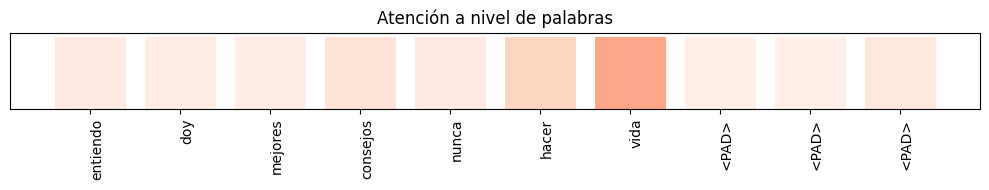

In [92]:
# Batch de prueba
model.eval()
with torch.no_grad():
    for features, labels in test_loader:
        features = features.float().to(device)
        outputs = model(features)

        # Acceder a los pesos de atención
        word_attention = model.attn_word_weights
        tweet_attention = model.attn_tweet_weights

        break  # Solo realizamos una iteración para visualizar el primer batch

def plot_attention(text, attention_weights, title):
    """
    Visualización de atención.
    - text: lista de palabras del tweet o colección de tweets.
    - attention_weights: pesos de atención asociados.
    - title: título de la gráfica.
    """
    fig, ax = plt.subplots(figsize=(10, 2))
    colors = plt.cm.Reds(attention_weights)

    ax.bar(range(len(text)), np.ones(len(text)), color=colors, edgecolor="white", linewidth=0.7)
    ax.set_xticks(range(len(text)))
    ax.set_xticklabels(text, rotation=90, fontsize=10, ha="left", color="black")
    ax.set_yticks([])  # Ocultar el eje Y
    ax.set_title(title)

    plt.tight_layout()
    plt.show()

tweets = tokenizer.tokenize(train_corpus_preprocesado[0][0])
print(f"Tweet: {train_corpus_preprocesado[0][0]}")

attention_weights = word_attention[0][0].cpu().numpy()  # Pesos de atención del primer tweet del primer usuario

plot_attention(tweets, attention_weights, "Atención a nivel de palabras")

Tweet: todas voces solo abanderados hipócrita progresía dueños verdad pobre q


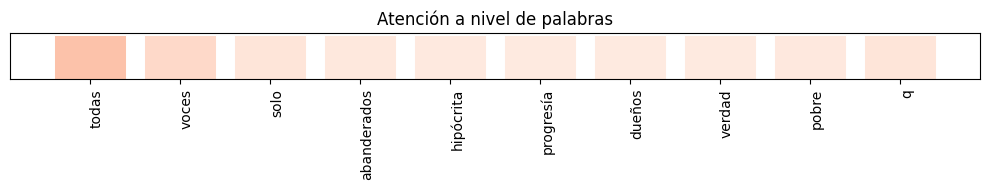

In [95]:
tweets = tokenizer.tokenize(train_corpus_preprocesado[2][4])
print(f"Tweet: {train_corpus_preprocesado[2][4]}")

attention_weights = word_attention[2][4].cpu().numpy()  # Pesos de atención del primer tweet del primer usuario

plot_attention(tweets, attention_weights, "Atención a nivel de palabras")

La verdad me sorprendió bastante para bien el rendimiento del modelo. No había tenido la oportunidad de construir un modelo from scratch que funcionara tan bien. Tuvo mucho que ver la limpieza de los datos y la preparación en un dataloader. Me tarde mucho tiempo en especial con la función *collate_fn* que nunca había usado antes. La idea de estructurar el dataset de manera jerárquica también ayudo bastante ya que cuando implemnté el modelo el manejo era sencillo ya que existían diferentes niveles usuario->tweet->word.

Me parece que el éxito de este modelo se debe en gran medida a la ateción jerárquica, la intuición detrás de esto me parece increible, ya que si bien los modelos de atención de la época ya podían diferenciar entre las palabras que eran mas importantes en una oración, la atención que iba primero a nivel de palabras y luego a nivel de oraciones permitió diferenciar diferentes tipos de atención, convirtiendose en un precedente de los transformers. Además la atención a nivel de oraciones va mas alla permitiendo poder identificar documentos (en el caso del artículo **Hierarchical Attention Networks for Document Classification**) o usuarios para este caso. En la gráfica se ve que los pesos de atención ponen mas énfasis en las palabras que tienen mas importancia para la predicción de la nacionalidad. Funciona bien.

## 4. Eché un ojo a los resultados que el profesor obtuvo sin deep learning y discuta lo siguiente respecto a tu modelo de RNN con atención en jerarquía

### 4.1) ¿Le ganó a la mejor propuesta de representaciones distribucionales según lo reportado por el profesor? Si no fue así: ¿Le ganó a la Bolsa de Términos con SVM reportada por el profesor?

No, mi modelo obtuvo un accuracy de 0.88 en el conjunto de test, mientras que el profesor reportó un score de 0.9432 usando representaciones distribucionales y métodos clásicos de aprendizaje automático, como SVM. Por lo tanto, no superó la propuesta del profesor basada en representaciones distribucionales o la Bolsa de Términos (Bag of Words, BoW) con SVM.

### 4.2) ¿Por que cree que NO o SI le ganó? Discuta.

Es probable que la razón por la que el modelo de atención jerárquica no haya superado a los métodos distribucionales se deba a un posible sobreajuste :hmm:. Al observar un accuracy menor en el conjunto de test (0.88) podría indicar que el modelo jerárquico con atención ha ajustado demasiado los datos de entrenamiento, fueron bastantes épocas, tal vez disminuyendo esto podría mejorar el rendimiento del modelo. Además, métodos como SVM con representaciones distribucionales son altamente efectivos en tareas de clasificación de texto cuando se dispone de datos bien estructurados y pueden ser menos propensos al sobreajuste que los modelos complejos como las RNN.

### 4.3) ¿Qué usó el primer lugar de la competencia? (Basile, et al.)

El primer lugar en la competencia (Basile et al.) utilizó una combinación de representaciones distribucionales (Word Embeddings) y un enfoque de Ensemble Learning con modelos de aprendizaje automático tradicionales como SVM y Naive Bayes. Estos métodos son muy efectivos para tareas de clasificación de texto y pueden mejorar la precisión al combinar varios clasificadores.

### 4.4) ¿Cuántos y que competidores usaron deep learning? En una o dos oraciones escriba qué hicieron, Y PORQUE crees que obtuvieron ese desempeño.

Pocos equipos en la competencia de 2017 utilizaron enfoques basados en deep learning. Aquellos que lo hicieron emplearon redes neuronales recurrentes (RNNs) y CNNs para la clasificación de texto. El desempeño relativamente más bajo de estos modelos puede deberse a que deep learning requiere grandes volúmenes de datos para generalizar bien, y en esta competencia, los métodos tradicionales, como las SVM con representaciones distribucionales, obtuvieron mejores resultados por su capacidad para manejar mejor conjuntos de datos pequeños o medianos.

## (Opcional) Haga una comparación que muestre si la atención en jerarquía es util vs no tenerla (e.g., sin atención o tener un solo nivel de atención)

Para esto, solo implementamos una clase nueva para otro modelo el cual no usa atención jerárquica. Usaremos los mismos hiperparámetros para entrenar, veamos como funciona

In [96]:
class HierarchicalRNNNoAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim_word, hidden_dim_tweet, output_dim, num_layers=1, bidirectional=True):
        super(HierarchicalRNNNoAttention, self).__init__()

        # RNN para las palabras en cada tweet
        self.rnn_word = nn.LSTM(embedding_dim, hidden_dim_word, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)

        # RNN para los tweets de cada usuario
        self.rnn_tweet = nn.LSTM(hidden_dim_word * 2 if bidirectional else hidden_dim_word, hidden_dim_tweet, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)

        # Capa fully connected para la clasificación final
        self.fc = nn.Linear(hidden_dim_tweet * 2 if bidirectional else hidden_dim_tweet, output_dim)

    def forward(self, padded_users):
        """
        - padded_users: tensor con shape (batch_size, num_tweets, tweet_length, embedding_dim)
        """

        # Obtenemos las dimensiones del tensor de entrada
        batch_size, num_tweets, tweet_length, embedding_dim = padded_users.size()

        # Procesamos cada tweet palabra por palabra usando el primer RNN (RNN de palabras)
        tweets_flat = padded_users.view(-1, tweet_length, embedding_dim)  # (batch_size * num_tweets, tweet_length, embedding_dim)
        rnn_word_out, (hidden_word, _) = self.rnn_word(tweets_flat)  # (batch_size * num_tweets, tweet_length, hidden_dim_word)

        # Tomamos el hidden state de la última capa del RNN de palabras para cada tweet
        hidden_word_out = hidden_word[-1] if not self.rnn_word.bidirectional else torch.cat((hidden_word[-2], hidden_word[-1]), dim=-1)

        # Redimensionamos para tener la representación de cada tweet por usuario
        tweets_repr = hidden_word_out.view(batch_size, num_tweets, -1)  # (batch_size, num_tweets, hidden_dim_word)

        # Procesamos las representaciones de los tweets por usuario usando el segundo RNN (RNN de tweets)
        rnn_tweet_out, (hidden_tweet, _) = self.rnn_tweet(tweets_repr)  # (batch_size, num_tweets, hidden_dim_tweet)

        # Tomamos el hidden state de la última capa del RNN de tweets para cada usuario
        hidden_tweet_out = hidden_tweet[-1] if not self.rnn_tweet.bidirectional else torch.cat((hidden_tweet[-2], hidden_tweet[-1]), dim=-1)

        # Clasificación final
        output = self.fc(hidden_tweet_out)  # (batch_size, output_dim)

        return output

In [97]:
model = HierarchicalRNNNoAttention(embedding_dim=_EMBEDDING_DIM,
                        hidden_dim_word=_HIDDEN_DIM_WORD_,
                        hidden_dim_tweet=_HIDDEN_DIM_TWEET_,
                        output_dim=_OUTPUT_DIM,
                        num_layers=_NUM_LAYERS).to(device)

In [98]:
print(model)

HierarchicalRNNNoAttention(
  (rnn_word): LSTM(100, 32, num_layers=2, batch_first=True, bidirectional=True)
  (rnn_tweet): LSTM(64, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)


In [99]:
# Entrenamiento
for epoch in range(_NUM_EPOCHS_):
    model.train()
    total_loss = 0
    total_correct = 0  # Para llevar un registro del número de predicciones correctas
    total_samples = 0  # Para contar el número de muestras procesadas

    for batch_idx, (features, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Pasar los datos al dispositivo
        features = features.float().to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Sumar la pérdida del lote actual
        total_loss += loss.item()

        # Calcular accuracy para el lote actual
        acc = accuracy(outputs, labels)
        total_correct += acc * labels.size(0)  # Acumular los correctos
        total_samples += labels.size(0)  # Acumular el total de muestras

        # Imprimir cada `log_interval` iteraciones
        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

    # Calcular la pérdida y el accuracy promedio para la epoch completa
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_samples

    # Imprimir al final de cada epoch
    print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")

Epoch 1, Batch 0, Loss: 1.9369, Accuracy: 0.2000
Epoch 1, Batch 50, Loss: 1.9354, Accuracy: 0.2000
Epoch 1, Batch 100, Loss: 1.9369, Accuracy: 0.1000
Epoch 1, Batch 150, Loss: 1.9201, Accuracy: 0.1000
Epoch 1, Batch 200, Loss: 1.9709, Accuracy: 0.2000
Epoch 1, Batch 250, Loss: 1.9541, Accuracy: 0.0000
Epoch 1, Batch 300, Loss: 1.9475, Accuracy: 0.1000
Epoch 1, Batch 350, Loss: 1.9299, Accuracy: 0.0000
Epoch 1, Batch 400, Loss: 1.9443, Accuracy: 0.0000
Epoch 1 completed, Avg Loss: 1.9482, Avg Accuracy: 0.1429
Epoch 2, Batch 0, Loss: 1.9400, Accuracy: 0.2000
Epoch 2, Batch 50, Loss: 1.9482, Accuracy: 0.2000
Epoch 2, Batch 100, Loss: 1.9413, Accuracy: 0.0000
Epoch 2, Batch 150, Loss: 1.9414, Accuracy: 0.3000
Epoch 2, Batch 200, Loss: 1.9408, Accuracy: 0.0000
Epoch 2, Batch 250, Loss: 1.9827, Accuracy: 0.1000
Epoch 2, Batch 300, Loss: 1.9558, Accuracy: 0.1000
Epoch 2, Batch 350, Loss: 1.9523, Accuracy: 0.1000
Epoch 2, Batch 400, Loss: 1.9378, Accuracy: 0.1000
Epoch 2 completed, Avg Loss: 1

In [100]:
# Poner el modelo en modo de evaluación
model.eval()

total_correct = 0  # Para contar el número de predicciones correctas
total_samples = 0  # Para contar el número total de ejemplos

# Desactivar el cálculo de gradientes para hacer la inferencia más eficiente
with torch.no_grad():
    for features, labels in test_loader:
        # Pasar los datos al dispositivo
        features = features.float().to(device)
        labels = labels.to(device)

        # Realizar la predicción
        outputs = model(features)

        # Calcular el número de predicciones correctas en este batch
        correct = accuracy(outputs, labels)

        # Acumular el número total de ejemplos
        total_correct += correct
        total_samples += labels.size(0)

In [101]:
# Calcular el accuracy final en todo el conjunto de test
test_accuracy = total_correct / total_samples * 10
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.1429


Quitando la atención, el modelo solo consiste en una LSTM bidireccional. Pierde batante, en realidad es muy pobre comparado con el otro.